In [1]:
import os
import yaml
import numpy as np
import pandas as pd

In [2]:
from tqdm import tqdm
from functools import partial
from collections import Counter
from multiprocessing import Pool, cpu_count

In [3]:
from beartype import beartype
from typing import Optional, List, Dict, Tuple

In [4]:
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set()

# Toolbox

In [5]:
@beartype
def get_threshold(meter: int, meta: Optional[List[dict]] = None, default: float = 5.) -> float:
    """
    Searches for activation threshold in meta file.

    Arguments:
        meter: int 
        meta: Optional[List[dict]]
        default: float 
    Returns:
        float
    """
    if meta is not None:
        for data in meta:
            if meter in data["meters"]:
                return float(data.get("on_power_threshold", default))
    return float(default)

In [6]:
@beartype
def read_dataset(dataset_path: str, house: int, labels_query: List[str] = [], threshold: float = 5.) -> Tuple[pd.DatetimeIndex, Dict[str, pd.DataFrame]]:
    """
    Reads dataset's house data. 

    Arguments:
        dataset_path: str
        house: int
        labels_query: List[str] - to read only specific appliances
        threshold: float - value to consider the appliance being switched on 
    Returns:
        Tuple[pd.DatetimeIndex, Dict[str, pd.DataFrame]]
    """
    if "uk-dale" in dataset_path:
        meta_path = os.path.join(
            dataset_path, "metadata/building%d.yaml" % house)
        # Read meta only for the UK-DALE dataset
        with open(meta_path, "r") as meta_stream:
            meta_data = yaml.safe_load(meta_stream)["appliances"]
    else:
        meta_data = None
    house_dir = os.path.join(dataset_path, "house_%d" % house)
    # Get the available appliances
    appliances_file = os.path.join(house_dir, "labels.dat")
    appliances = pd.read_csv(appliances_file, header=None, names=[
        "channel", "label"], delim_whitespace=True)
    if labels_query:
        # Drop the rest
        appliances = appliances[appliances.label.isin(labels_query)]
    data = {}
    # Minimal and maximal timestamps for particular label
    min_ts = []
    max_ts = []
    labels = appliances.label.values
    counts = {k: v for k, v in Counter(labels).items() if v > 1}
    for i in reversed(range(len(labels))):
        item = labels[i]
        if item in counts and counts[item]:
            labels[i] += str(counts[item])
            counts[item] -= 1
    appliances.loc[:, "label"] = labels
    for channel, label in tqdm(appliances.values):
        # Skip aggregated measurements
        if "uk-dale" in dataset_path and label.startswith("aggregate"):
            continue
        elif "redd" in dataset_path and label.startswith("mains"):
            continue
        channel_path = os.path.join(house_dir, "channel_%d.dat" % channel)
        channel_data = pd.read_csv(channel_path, names=["ts", "power"],
                                   delim_whitespace=True)
        channel_data["power"] = channel_data["power"].values > get_threshold(
            channel, meta=meta_data, default=threshold)
        channel_data = channel_data.rename(columns={"power": "status"})
        channel_data.loc[0, "status"] = False
        min_ts.append(channel_data["ts"].min())
        max_ts.append(channel_data["ts"].max())
        data[label] = channel_data
    global_max_ts = max(max_ts)
    global_min_ts = min(min_ts)
    timeline = pd.date_range(global_min_ts * 10 ** 9,
                             global_max_ts * 10 ** 9, freq="1S")
    return timeline, data

In [7]:
@beartype
def fill_gaps(data: pd.DataFrame, timeline: pd.DatetimeIndex, delay: int = 60) -> np.ndarray:
    """
    Performs interpolation of missing values
    
    Arguments:
        data: pd.DataFrame 
        timeline: pd.DatetimeIndex
        delay: int - number of seconds to consider an appliance as switched on
    Returns:
        np.ndarray
    """
    data["delta"] = data["ts"].diff()
    data.loc[0, "delta"] = 0
    # Silence assumption:
    # If no data available more than `delay` seconds
    # appliance is considered as switched off
    data.loc[data.delta > delay, "status"] = False
    data = data.set_index("ts")
    data.index = pd.to_datetime(10 ** 9 * data.index)
    data.index = pd.DatetimeIndex(data.index)
    # Project timeline to the global timeline
    data = data.reindex(timeline, fill_value=np.nan)
    data.iloc[-1, data.columns.get_loc("status")] = False
    return (data["status"][::-1].interpolate(method="pad"))[::-1].values[None, :]

In [8]:
def get_stats(dataset: Tuple[pd.DatetimeIndex, Dict[str, pd.DataFrame]], delay: int = 60, n_jobs: int = 1) -> np.ndarray:
    """
    Computes a vector with number of concurrent loads over the global timeline
    
    Arguments:
        dataset: Tuple[pd.DatetimeIndex, Dict[str, pd.DataFrame]]
        delay: int - number of seconds to consider an appliance as switched on
        n_jobs: int
    Returns:
        np.ndarray
    """
    timeline, data = dataset
    fill_gaps_partial = partial(fill_gaps, timeline=timeline, delay=delay)
    if n_jobs == -1:
        n_jobs = cpu_count()
    with Pool(n_jobs) as parallel:
        results = parallel.map(fill_gaps_partial, list(data.values()))
    # Per appliance activation status at EACH TIMESTAMP 
    stats = np.concatenate(results, axis=0)
    concurrency = stats.sum(axis=0)
    return concurrency[concurrency>0]

# Read data

In [9]:
uk_dale_dataset_path="/home/arx7ti/datasets/uk-dale/"
redd_dataset_path="/home/arx7ti/datasets/redd/"

In [10]:
uk_dale_data = {}
for house in range(1,6):
    uk_dale_data[house] = read_dataset(uk_dale_dataset_path, house)
    
redd_data = {}
for house in range(1,7):
    redd_data[house] = read_dataset(redd_dataset_path, house)

100%|██████████| 17/17 [00:00<00:00, 20.77it/s]


In [11]:
uk_dale_5apps = read_dataset(uk_dale_dataset_path, 1,
                            labels_query=["kettle", "fridge", "washing_machine",
                                          "microwave", "dishwasher"],
                            threshold=5.)

100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


# The UK-DALE dataset summary

# Warning! 
This might be very memory consuming. 

`n_jobs=10` can take up to 60 GB RAM for house 1

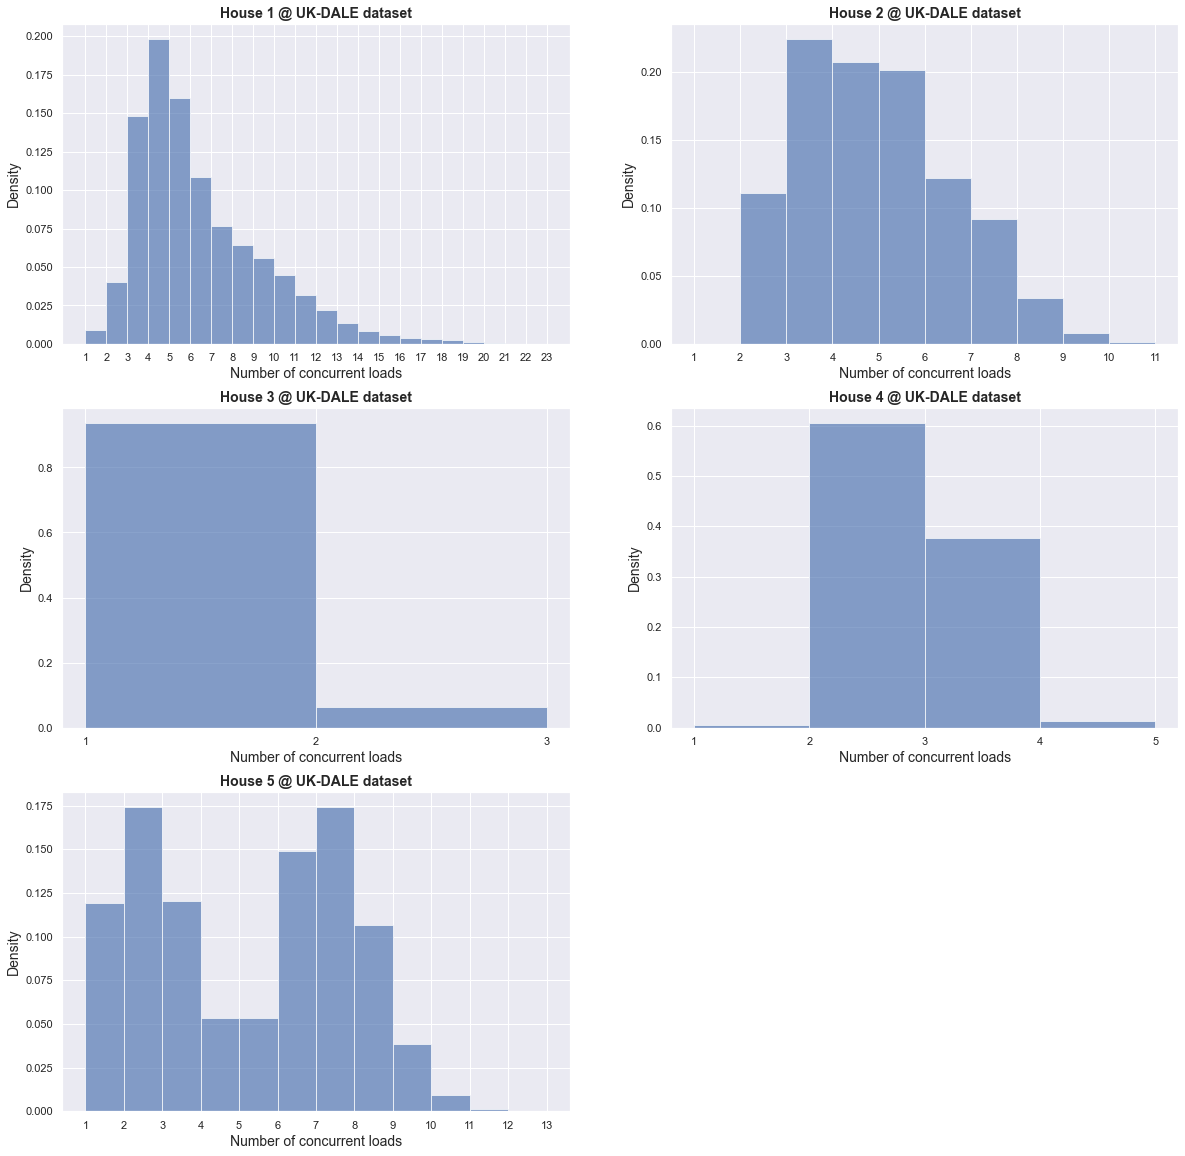

In [12]:
_uk_dale_summary = {}

fig = plt.figure(figsize=(20, 20))
for house, data in uk_dale_data.items():

    concurrency = get_stats(data, n_jobs=10)
    max_appliances = concurrency.max()

    ax = fig.add_subplot(3, 2, house)

    freqs, _, _ = ax.hist(concurrency, bins=range(
        1, max_appliances+1), density=True, alpha=0.66)

    ax.set_title("House %d @ UK-DALE dataset" %
                 house, fontsize=14, fontweight=900)
    ax.set_ylabel("Density", fontsize=14)
    ax.set_xlabel("Number of concurrent loads", fontsize=14)
    ax.set_xticks(range(1, max_appliances+1))

    _uk_dale_summary[house] = [freqs[0], np.sum(freqs[1:5]), np.sum(
        freqs[5:9]), np.sum(freqs[9:]), max_appliances]

    if house == 6:
        ax.set_visible(False)
    
    if house == 1:
        uk_dale_plot_data = concurrency

    del concurrency

uk_dale_summary = pd.DataFrame([v for k, v in _uk_dale_summary.items()],
                               columns=["1", "2-5", "6-9", ">=10", "max"])

In [14]:
# Check for consistency
assert(uk_dale_summary.iloc[:, :-1].sum(axis=1).sum() == 5.)

## Table for paper 

In [15]:
# To percentages
uk_dale_summary.iloc[:, :-1] = np.round(uk_dale_summary.iloc[:, :-1]*100, 2)
uk_dale_summary

,1,2-5,6-9,>=10,max
0,0.88,54.66,30.58,13.88,23
1,0.00,74.36,25.53,0.10,11
2,93.66,6.34,0.00,0.00,3
3,0.60,99.40,0.00,0.00,5
4,11.90,40.15,46.81,1.13,13


## Plot for paper 

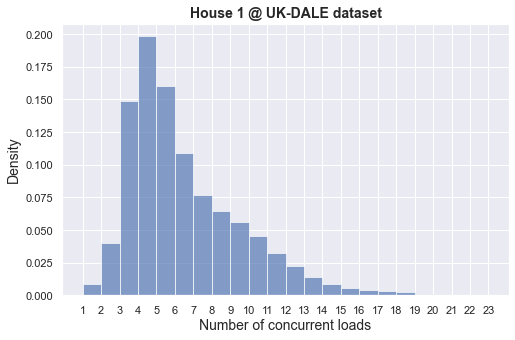

In [17]:
plt.figure(figsize=(8, 5))
_, _, _ = plt.hist(uk_dale_plot_data, bins=range(
    1, uk_dale_plot_data.max()+1), density=True, alpha=0.66)

plt.title("House 1 @ UK-DALE dataset", fontsize=14, fontweight=900)
plt.ylabel("Density", fontsize=14)
plt.xlabel("Number of concurrent loads", fontsize=14)
plt.xticks(range(1, uk_dale_plot_data.max()+1))
plt.savefig("ukdale.png", bbox_inches="tight")

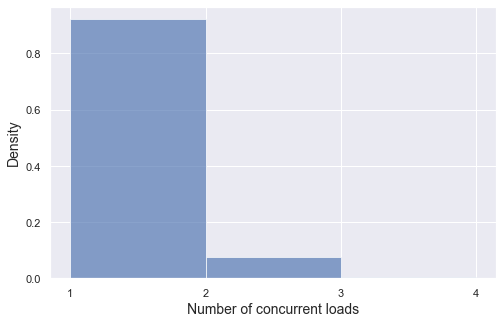

In [18]:
concurrency_uk_dale_5apps = get_stats(uk_dale_5apps, n_jobs=10)

plt.figure(figsize=(8, 5))
freqs, _, _ = plt.hist(concurrency_uk_dale_5apps, bins=range(
    1, concurrency_uk_dale_5apps.max()+1), density=True, alpha=0.66)

plt.ylabel("Density", fontsize=14)
plt.xlabel("Number of concurrent loads", fontsize=14)
plt.xticks(range(1, concurrency_uk_dale_5apps.max()+1))

_uk_dale_5apps_summary = [freqs[0], np.sum(freqs[1:2]), np.sum(
    freqs[2:]), concurrency_uk_dale_5apps.max()]

uk_dale_5apps_summary= pd.DataFrame([_uk_dale_5apps_summary], columns=[
                               "1", "2-3", ">=4", "max"])

In [19]:
# Check for consistency
assert(uk_dale_5apps_summary.iloc[:, :-1].sum(axis=1).sum() == 1.)

## Statistics for paper 

In [20]:
# To percentages
uk_dale_5apps_summary.iloc[:, :-1] = np.round(uk_dale_5apps_summary.iloc[:, :-1]*100, 2)
uk_dale_5apps_summary

,1,2-3,>=4,max
0,92.06,7.58,0.36,4


# The REDD dataset summary

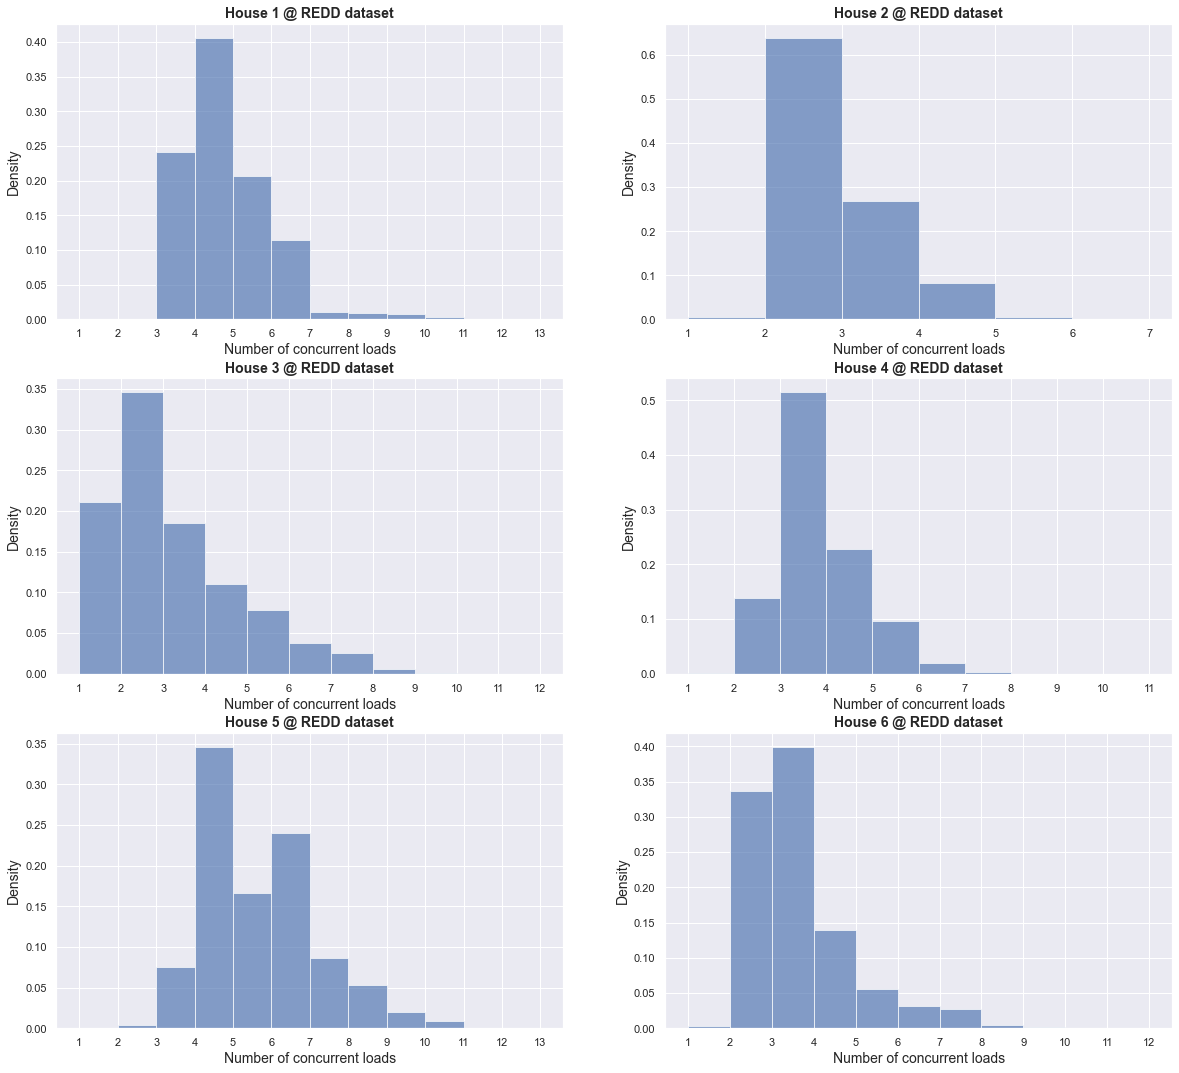

In [21]:
_redd_summary = {}

fig = plt.figure(figsize=(20, 25))
for house, data in redd_data.items():

    concurrency = get_stats(data, n_jobs=10)
    max_appliances = concurrency.max()

    ax = fig.add_subplot(4, 2, house)

    freqs, _, _ = ax.hist(concurrency, bins=range(
        1, max_appliances+1), density=True, alpha=0.66)

    ax.set_title("House %d @ REDD dataset" %
                 house, fontsize=14, fontweight=900)
    ax.set_ylabel("Density", fontsize=14)
    ax.set_xlabel("Number of concurrent loads", fontsize=14)
    ax.set_xticks(range(1, max_appliances+1))

    _redd_summary[house] = [freqs[0], np.sum(freqs[1:5]), np.sum(
        freqs[5:9]), np.sum(freqs[9:]), max_appliances]
    
    if house == 5:
        redd_plot_data = concurrency

    del concurrency

redd_summary = pd.DataFrame([v for k, v in _redd_summary.items()], columns=[
                            "1", "2-5", "6-9", ">=10", "max"])

In [22]:
# Check for consistency
assert(redd_summary.iloc[:, :-1].sum(axis=1).sum() == 6.)

## Table for paper 

In [23]:
# To percentages
redd_summary.iloc[:, :-1] = np.round(redd_summary.iloc[:, :-1]*100, 2)
redd_summary

,1,2-5,6-9,>=10,max
0,0.00,85.38,14.16,0.46,13
1,0.41,99.52,0.07,0.00,7
2,21.10,71.90,6.98,0.01,12
3,0.08,97.65,2.27,0.00,11
4,0.01,59.18,39.90,0.91,13
5,0.30,93.17,6.51,0.01,12


## Plot for paper

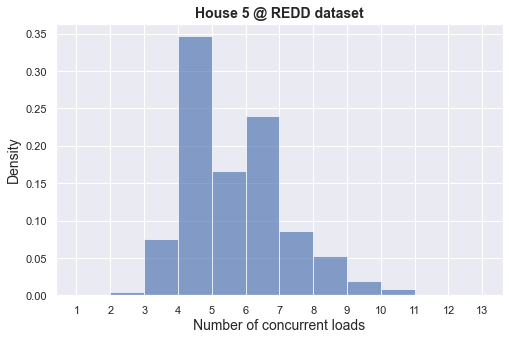

In [24]:
plt.figure(figsize=(8, 5))
_, _, _ = plt.hist(redd_plot_data, bins=range(
    1, redd_plot_data.max()+1), density=True, alpha=0.66)

plt.title("House 5 @ REDD dataset", fontsize=14, fontweight=900)
plt.ylabel("Density", fontsize=14)
plt.xlabel("Number of concurrent loads", fontsize=14)
plt.xticks(range(1, redd_plot_data.max()+1))
plt.savefig("redd.png", bbox_inches="tight")